In [107]:
import jax
import jax.numpy as jnp
import numpy as np
from jaxmao.layers import Dense, BatchNorm
from jaxmao.modules import Module
from jaxmao.optimizers import GradientDescent

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [108]:
seed = 2
key = jax.random.PRNGKey(seed)

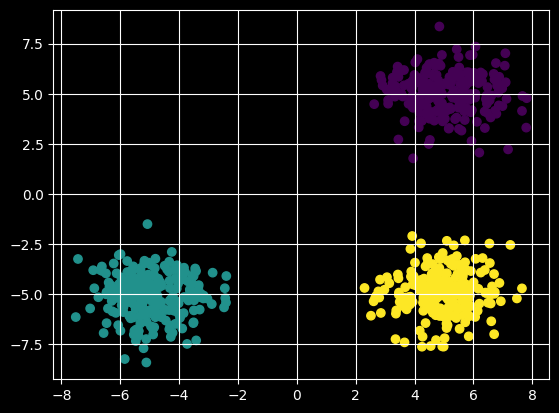

In [109]:
num_samples = 250
x1 = np.column_stack([
    np.random.normal(5, 1, (num_samples,)),
    np.random.normal(5, 1, (num_samples,)),
])

x2 = np.column_stack([
    np.random.normal(-5, 1, (num_samples,)),
    np.random.normal(-5, 1, (num_samples,)),
])

x3 = np.column_stack([
    np.random.normal(5, 1, (num_samples,)),
    np.random.normal(-5, 1, (num_samples,)),
])

x = np.vstack((x1, x2, x3))
y = np.hstack((np.zeros(num_samples), np.ones(num_samples), np.zeros(num_samples)+2)).reshape(-1,1)
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.grid()
plt.show()

In [110]:
enc = OneHotEncoder(sparse_output=False)
y_enc = enc.fit_transform(y)

In [111]:
class ClasterClassifier(Module):
    def __init__(self):
        super().__init__()
        self.add("fc1", Dense(2, 16))
        self.add("bn1", BatchNorm(16))
        self.add("fc2", Dense(16, 3, activation=jnp.tanh))
    
    def forward(self, params, x, state):
        x, state = self.forward_with_state(params, x, "fc1", state)
        x, state = self.forward_with_state(params, x, "bn1", state)
        x, state = self.forward_with_state(params, x, "fc2", state)
        return x, state

model = ClasterClassifier()
model.forward = jax.jit(model.forward)
model.pure_forward = jax.jit(model.pure_forward)
model.init_params(key)

y_pred = model(model.params, x)

In [112]:
from sklearn.utils import shuffle

def loss_fn(model, params, x, y_true, state):
    y_pred, new_state = model.pure_forward(params, x, state)
    loss = jnp.mean((y_pred - y_true)**2)
    return loss, new_state

def training_loop(model, optimizer, x, y_true, epochs, lr=0.01, batch_size=32):
    num_batch = len(x) // batch_size
    for epoch in range(epochs):
        losses = 0
        x, y_true = shuffle(x, y_true)
        for n in range(num_batch):
            # Compute gradients
            loss_grad_fn = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)
            (loss, new_state), gradients = loss_grad_fn(model, model.params, 
                                                          x[n*batch_size:(n+1)*batch_size], 
                                                          y_true[n*batch_size:(n+1)*batch_size], 
                                                          model.state)
            losses = losses + loss
            # Update model parameters
            model.params, optim_state = optimizer.step(model.params, gradients, lr=lr)
            model.update_state(new_state)
            
        print('epoch {}: {}'.format(epoch, losses / num_batch))

In [115]:
optimizer = GradientDescent()
epochs = 5
lr = 0.01

training_loop(model, optimizer, x, y_enc, epochs, lr=lr, batch_size=4)

epoch 0: 0.12996505200862885
epoch 1: 0.09838677942752838
epoch 2: 0.09033968299627304
epoch 3: 0.09600741416215897
epoch 4: 0.09373830258846283


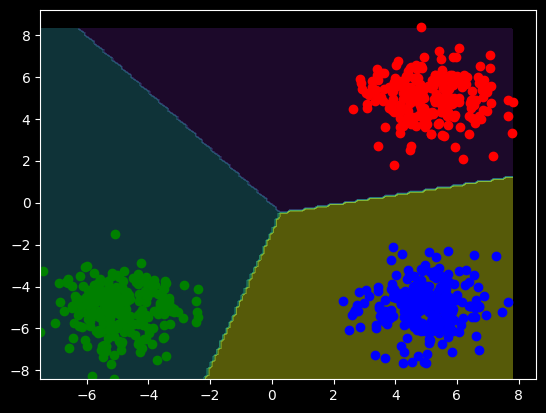

In [116]:
step = 0.1
xx, yy = np.meshgrid(
    np.arange(x[:,0].min(), x[:,0].max(), step), np.arange(x[:,1].min(), x[:,1].max(), step)
)
X_mesh = np.c_[xx.ravel(), yy.ravel()]
countour_color = model(model.params, X_mesh).argmax(axis=1)
plt.contourf(xx, yy, countour_color.reshape(xx.shape), alpha=0.4)

plt.scatter(x[y.ravel()==0][:, 0], x[y.ravel()==0][:, 1], c='r')
plt.scatter(x[y.ravel()==1][:, 0], x[y.ravel()==1][:, 1], c='g')
plt.scatter(x[y.ravel()==2][:, 0], x[y.ravel()==2][:, 1], c='b')
plt.show()